In [15]:
import numpy as np
import pandas as pd

import ipympl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

print(matplotlib.get_backend())

import data_util as du
import performance_util as pu
import bayes_classifier as bayes
import naive_bayes_classifier as nb
import knn_classifier as knn

from PCA import PCA
import kmeans

%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
# %matplotlib agg

module://ipykernel.pylab.backend_inline


In [16]:
data_dir = '../data/Medical_data.csv'
test_data_dir = '../data/test_medical.csv'
random_seed = 1
np.set_printoptions(precision=4)

In [17]:
label_map = {'HEALTHY':0, 'SURGERY':1, 'MEDICATION':2}
X_train, Y_train = du.load_medical(data_dir, label_map = label_map)
X_test, Y_test = du.load_medical(test_data_dir, label_map = label_map)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(X_train[:3, :])
print(Y_train[:3, :])

(3000, 3)
(3000, 1)
(3000, 3)
(3000, 1)
[[ 1.6315 -0.2644  2.5346]
 [ 0.154   1.4195  1.3331]
 [ 2.0217  0.262   2.88  ]]
[[0]
 [1]
 [0]]


/home/manas/Academics/sem_7/ell409/assignment/assign1/src/data_util.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = df[['TEST1' , 'TEST2', 'TEST3']].as_matrix()
/home/manas/Academics/sem_7/ell409/assignment/assign1/src/data_util.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y = df[['Health']].as_matrix()


### VISUALIZATION

(array([1000., 1000., 1000.]),
 array([0.    , 0.6667, 1.3333, 2.    ]),
 <a list of 3 Patch objects>)

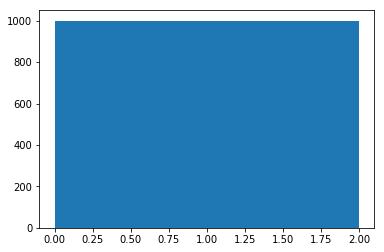

In [18]:
plt.hist(Y_train, bins = 3)

FigureCanvasNbAgg()

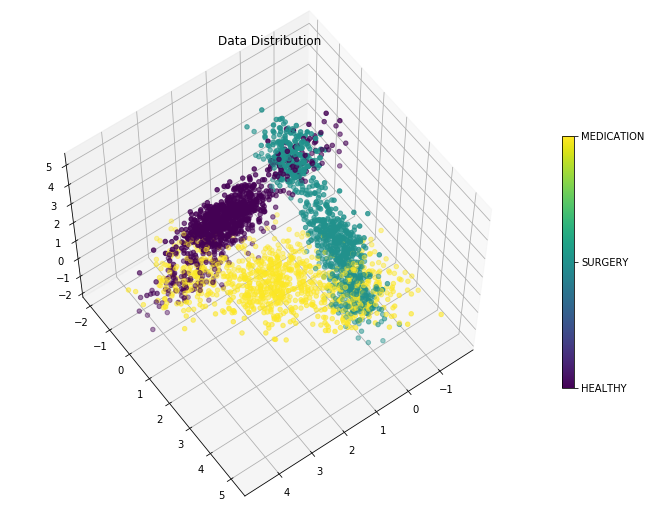

In [19]:
%matplotlib widget
fig = plt.figure(figsize=(9,7))

ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=60, azim=54)
# ax = plt.axes(projection='3d')
cax = ax.scatter3D(X_train[:,0], X_train[:,1], X_train[:,2], c = Y_train[:,0])
ax.set_title('Data Distribution')


# cax = ax.imshow(X, interpolation='nearest', cmap=cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1, 2], shrink = 0.5)
cbar.ax.set_yticklabels(['HEALTHY', 'SURGERY', 'MEDICATION'])

plt.savefig('img/3d_medical.png')

### PCA

In [20]:
pca = PCA(n_components = 2)
pca.fit(X_train)
print(np.sum(pca.explained_variance_ratio_))

0.9352761773710135


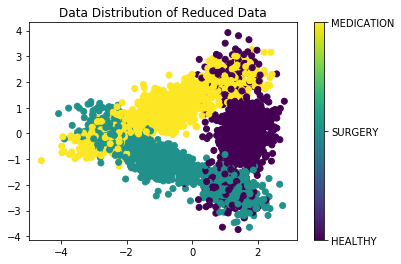

In [21]:
X_transformed = pca.transform(X_train)

%matplotlib inline
fig = plt.figure()

cax = plt.scatter(X_transformed[:,0], X_transformed[:,1], c = Y_train[:,0])
plt.title('Data Distribution of Reduced Data')

cbar = fig.colorbar(cax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['HEALTHY', 'SURGERY', 'MEDICATION'])
plt.savefig('img/2d_medical.png')

## SUPERVISED LEARNING

### Data Preprocessing

In [10]:
X_train, Y_train, X_dev, Y_dev = du.split_data(X_train, Y_train, train_ratio = 0.75, random_state = random_seed)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_dev.shape)
print(Y_dev.shape)

(2250, 3)
(2250, 1)
(3000, 3)
(3000, 1)
(750, 3)
(750, 1)


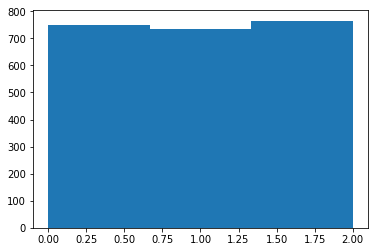

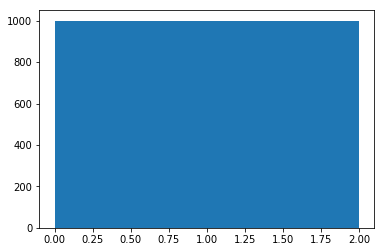

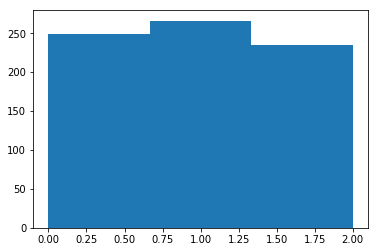

In [11]:
%matplotlib inline
plt.hist(Y_train, bins = 3)
plt.show()
plt.hist(Y_test, bins = 3)
plt.show()
plt.hist(Y_dev, bins = 3)
plt.show()

In [12]:
# Normalize w.r.t train data
# https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

X_train, mu, std = du.normalize(X_train)
X_dev = (X_dev - mu) / std
X_test = (X_test - mu) / std

#### REDUCTION to 2 COMPONENTS - PCA

In [13]:
pca_2 = PCA(n_components = 2)
pca_2.fit(X_train)
print(np.sum(pca_2.explained_variance_ratio_))

0.935310859719806


In [14]:
X_train_reduced = pca_2.transform(X_train)
X_dev_reduced = pca_2.transform(X_dev)
X_test_reduced = pca_2.transform(X_test)

### KNN CLASSIFIER

####  3D DATA

##### Training and Parameter Tuning

In [24]:
# (no. of neighbours, minkowski parameter) 
knn_parameters = [(1, 1), (5, 1), (10, 1), (15, 1), 
                  (1, 2), (5, 2), (10, 2), (15, 2),
                  (1, 3), (5, 3), (10, 3), (15, 3), 
                  (1, np.inf), (5, np.inf), (10, np.inf), (15, np.inf), 
                  (1, -np.inf), (5, -np.inf), (10, -np.inf), (15, -np.inf)]

    
for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()

Number of Neighbours = 1 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8693333333333333
Precision per Class
[0.9024 0.8609 0.8445]
Recall per Class
[0.8916 0.8609 0.8553]
F1 Score per Class
[0.897  0.8609 0.8499]
Macro Average Precision, Recall and F1 Score
[0.8693 0.8693 0.8693]
Micro Average Precision, Recall and F1 Score
[0.8693 0.8693 0.8693]


Number of Neighbours = 5 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.9066666666666666
Precision per Class
[0.9417 0.8905 0.8898]
Recall per Class
[0.9076 0.9173 0.8936]
F1 Score per Class
[0.9243 0.9037 0.8917]
Macro Average Precision, Recall and F1 Score
[0.9073 0.9062 0.9068]
Micro Average Precision, Recall and F1 Score
[0.9067 0.9067 0.9067]


Number of Neighbours = 10 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.9066666666666666
Precision per Class
[0.9496 0.8826 0.8918]
Recall per Class
[0.9076 0.9323 0.8766]
F1 Score per Class
[0.9281 0.9068 0.8841]
Macro Average Precision, Recall and F1 Score
[0.908  0.9055 0.9067]
M

#####  Testing

In [25]:
knn_parameters = [(5, 2)]

for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Test Set = ", pu.model_accuracy(Y_pred, Y_test))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_test, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_test, 3))
    
    print()
    print()

Number of Neighbours = 5 , Minkowski Parameter = 2
Accuracy on Test Set =  0.8843333333333333
Precision per Class
[0.9477 0.8307 0.8832]
Recall per Class
[0.888 0.903 0.862]
F1 Score per Class
[0.9169 0.8654 0.8725]
Macro Average Precision, Recall and F1 Score
[0.8872 0.8843 0.8858]
Micro Average Precision, Recall and F1 Score
[0.8843 0.8843 0.8843]




##### Training and Parameter Tuning

In [26]:
# (no. of neighbours, minkowski parameter) 
knn_parameters = [(1, 1), (5, 1), (10, 1), (15, 1), 
                  (1, 2), (5, 2), (10, 2), (15, 2),
                  (1, 3), (5, 3), (10, 3), (15, 3), 
                  (1, np.inf), (5, np.inf), (10, np.inf), (15, np.inf), 
                  (1, -np.inf), (5, -np.inf), (10, -np.inf), (15, -np.inf)]

np.set_printoptions(precision=4)
    
for k1,p1 in knn_parameters:
    model = knn.knn_model(k = k1, p = p1)
    model.train(X_train_reduced, Y_train)
    Y_pred = model.predict(X_dev_reduced)
    
    print("Number of Neighbours = %s , Minkowski Parameter = %s" % (str(k1), str(p1)))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()

Number of Neighbours = 1 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8213333333333334
Precision per Class
[0.8704 0.8427 0.7529]
Recall per Class
[0.8635 0.7857 0.817 ]
F1 Score per Class
[0.8669 0.8132 0.7837]
Macro Average Precision, Recall and F1 Score
[0.822  0.8221 0.8221]
Micro Average Precision, Recall and F1 Score
[0.8213 0.8213 0.8213]


Number of Neighbours = 5 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.836
Precision per Class
[0.9269 0.8358 0.7605]
Recall per Class
[0.8153 0.8421 0.8511]
F1 Score per Class
[0.8675 0.839  0.8032]
Macro Average Precision, Recall and F1 Score
[0.8411 0.8361 0.8386]
Micro Average Precision, Recall and F1 Score
[0.836 0.836 0.836]


Number of Neighbours = 10 , Minkowski Parameter = 1
Accuracy on Dev Set =  0.8573333333333333
Precision per Class
[0.9258 0.8316 0.822 ]
Recall per Class
[0.8514 0.891  0.8255]
F1 Score per Class
[0.887  0.8603 0.8238]
Macro Average Precision, Recall and F1 Score
[0.8598 0.856  0.8579]
Micro Average Pre

#### Performance After PCA decreased using KNN Classifier
#### KNN BEST PARAMETERS 
#### 3D DATA, k = 5, p = 2

### BAYES CLASSIFIER

#### GMM class conditional distribution

In [27]:
dimension = X_train.shape[1]

gmm_parameters = [[2, 0.01, 100, dimension, 0.0001],  [2, 0.001, 100, dimension, 0.0001],
                  [2, 0.0001, 100, dimension, 0.0001],[2, 0.00001, 100, dimension, 0.0001],
                  [3, 0.01, 100, dimension, 0.0001],  [3, 0.001, 100, dimension, 0.0001],
                  [3, 0.0001, 100, dimension, 0.0001],[3, 0.00001, 100, dimension, 0.0001],
                  [4, 0.01, 100, dimension, 0.0001],  [4, 0.001, 100, dimension, 0.0001],
                  [4, 0.0001, 100, dimension, 0.0001],[4, 0.00001, 100, dimension, 0.0001],
                  [5, 0.01, 100, dimension, 0.0001],  [5, 0.001, 100, dimension, 0.0001],
                  [5, 0.0001, 100, dimension, 0.0001],[5, 0.00001, 100, dimension, 0.0001],]

    
for par in gmm_parameters:
    model = bayes.bayes_classifier(estimator_type = 'GMM', param = par)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Number of Components = %s , Number of max EM iterations = %s" % (str(par[0]), str(par[2])))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()


Class 0
Converged after 71 iterations
Class 1
Converged after 49 iterations
Class 2
Converged after 37 iterations
Number of Components = 2 , Number of max EM iterations = 100
Accuracy on Dev Set =  0.912
Precision per Class
[0.9662 0.8897 0.8836]
Recall per Class
[0.9197 0.9398 0.8723]
F1 Score per Class
[0.9424 0.9141 0.8779]
Macro Average Precision, Recall and F1 Score
[0.9132 0.9106 0.9119]
Micro Average Precision, Recall and F1 Score
[0.912 0.912 0.912]


Class 0
Converged after 86 iterations
Class 1
Converged after 57 iterations
Class 2
Didn't converge, ran for 100 iterations
Number of Components = 2 , Number of max EM iterations = 100
Accuracy on Dev Set =  0.9146666666666666
Precision per Class
[0.9703 0.8929 0.8846]
Recall per Class
[0.9197 0.9398 0.8809]
F1 Score per Class
[0.9443 0.9158 0.8827]
Macro Average Precision, Recall and F1 Score
[0.9159 0.9135 0.9147]
Micro Average Precision, Recall and F1 Score
[0.9147 0.9147 0.9147]


Class 0
Converged after 28 iterations
Class 1


#### Best Parameters [4, 0.01, 100, dimension, 0.0001]

In [28]:
best_par = [4, 0.01, 100, dimension, 0.0001]
model = bayes.bayes_classifier(estimator_type = 'GMM', param = best_par)
model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Number of Components = %s , Number of max EM iterations = %s" % (str(par[0]), str(par[2])))
print("Accuracy on Test Set = ", pu.model_accuracy(Y_pred, Y_test))
print("Precision per Class")
print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
print("Recall per Class")
print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
print("F1 Score per Class")
print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
print("Macro Average Precision, Recall and F1 Score")
print(pu.model_macro_average(Y_pred, Y_test, 3))
print("Micro Average Precision, Recall and F1 Score")
print(pu.model_micro_average(Y_pred, Y_test, 3))

print()
print()


Class 0
Converged after 79 iterations
Class 1
Didn't converge, ran for 100 iterations
Class 2
Didn't converge, ran for 100 iterations
Number of Components = 5 , Number of max EM iterations = 100
Accuracy on Dev Set =  0.9
Precision per Class
[0.9604 0.8486 0.8993]
Recall per Class
[0.897 0.919 0.884]
F1 Score per Class
[0.9276 0.8824 0.8916]
Macro Average Precision, Recall and F1 Score
[0.9027 0.9    0.9014]
Micro Average Precision, Recall and F1 Score
[0.9 0.9 0.9]




#### Multinormal class conditional distribution

In [31]:
dimension = X_train.shape[1]
par = []
model = bayes.bayes_classifier(estimator_type = 'MultiNormal', param = par)
model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
    
print("Accuracy on Test Set = ", pu.model_accuracy(Y_pred, Y_test))
print("Precision per Class")
print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
print("Recall per Class")
print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
print("F1 Score per Class")
print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
print("Macro Average Precision, Recall and F1 Score")
print(pu.model_macro_average(Y_pred, Y_test, 3))
print("Micro Average Precision, Recall and F1 Score")
print(pu.model_micro_average(Y_pred, Y_test, 3))

print()
print()

Class 0
Class 1
Class 2
Accuracy on Test Set =  0.5026666666666667
Precision per Class
[0.5006 0.5886 0.4485]
Recall per Class
[0.832 0.319 0.357]
F1 Score per Class
[0.6251 0.4137 0.3976]
Macro Average Precision, Recall and F1 Score
[0.5126 0.5027 0.5076]
Micro Average Precision, Recall and F1 Score
[0.5027 0.5027 0.5027]




#### Parzen Window

In [13]:
dimension = X_train.shape[1]

parzen_parameters = [['hypercube', 0.25, 3, True], ['hypercube', 0.5, 3, True],
                     ['hypercube', 0.75, 3, True], ['hypercube', 1.0, 3, True],
                     ['gaussian', 0.25, 3, True], ['gaussian', 0.5, 3, True],
                     ['gaussian', 0.75, 3, True], ['gaussian', 1.0, 3, True]]
    
for par in parzen_parameters:
    model = bayes.bayes_classifier(estimator_type = 'Parzen', param = par)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()


Class 0
Class 1
Class 2
Accuracy on Dev Set =  0.7826666666666666
Precision per Class
[0.6734 0.8704 0.8865]
Recall per Class
[0.9438 0.7068 0.6979]
F1 Score per Class
[0.786  0.7801 0.781 ]
Macro Average Precision, Recall and F1 Score
[0.8101 0.7828 0.7962]
Micro Average Precision, Recall and F1 Score
[0.7827 0.7827 0.7827]


Class 0
Class 1
Class 2
Accuracy on Dev Set =  0.9013333333333333
Precision per Class
[0.9449 0.8664 0.9009]
Recall per Class
[0.8956 0.9511 0.8511]
F1 Score per Class
[0.9196 0.9068 0.8753]
Macro Average Precision, Recall and F1 Score
[0.9041 0.8993 0.9017]
Micro Average Precision, Recall and F1 Score
[0.9013 0.9013 0.9013]


Class 0
Class 1
Class 2
Accuracy on Dev Set =  0.8986666666666666
Precision per Class
[0.9908 0.8454 0.8816]
Recall per Class
[0.8675 0.9662 0.8553]
F1 Score per Class
[0.9251 0.9018 0.8683]
Macro Average Precision, Recall and F1 Score
[0.9059 0.8963 0.9011]
Micro Average Precision, Recall and F1 Score
[0.8987 0.8987 0.8987]


Class 0
Class

#### Best Parameters ['gaussian', 0.25, 3, True]

In [14]:
dimension = X_train.shape[1]
par = ['gaussian', 0.25, 3, True]
model = bayes.bayes_classifier(estimator_type = 'Parzen', param = par)
model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_test))
print("Precision per Class")
print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
print("Recall per Class")
print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
print("F1 Score per Class")
print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
print("Macro Average Precision, Recall and F1 Score")
print(pu.model_macro_average(Y_pred, Y_test, 3))
print("Micro Average Precision, Recall and F1 Score")
print(pu.model_micro_average(Y_pred, Y_test, 3))

print()
print()

Class 0
Class 1
Class 2
Accuracy on Dev Set =  0.888
Precision per Class
[0.993 0.804 0.9  ]
Recall per Class
[0.85  0.968 0.846]
F1 Score per Class
[0.9159 0.8784 0.8722]
Macro Average Precision, Recall and F1 Score
[0.899  0.888  0.8935]
Micro Average Precision, Recall and F1 Score
[0.888 0.888 0.888]




# Naive Bayes Classifier
#### GMM Class Conditional Distributions

In [15]:
import naive_bayes_classifier as nb
dimension = X_train.shape[1]

gmm_parameters = [[[2, 0.01, 100, dimension, 0.0001]]*3, [[2, 0.0001, 100, dimension, 0.0001]]*3,
                  [[3, 0.01, 100, dimension, 0.0001]]*3, [[3, 0.0001, 100, dimension, 0.0001]]*3,
                  [[4, 0.01, 100, dimension, 0.0001]]*3, [[4, 0.0001, 100, dimension, 0.0001]]*3,
                  [[5, 0.01, 100, dimension, 0.0001]]*3, [[5, 0.0001, 100, dimension, 0.0001]]*3,]

distributions = ['GMM', 'GMM', 'GMM']
for par in gmm_parameters:
    model = nb.naive_bayes_classifier(distrib = distributions, param = par)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Number of Components = %s , Number of max EM iterations = %s" % (str(par[0]), str(par[2])))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()


Converged after 2 iterations
Converged after 2 iterations
Converged after 15 iterations
Converged after 4 iterations
Converged after 2 iterations
Converged after 2 iterations
Converged after 2 iterations
Converged after 2 iterations
Converged after 2 iterations
Number of Components = [2, 0.01, 100, 3, 0.0001] , Number of max EM iterations = [2, 0.01, 100, 3, 0.0001]
Accuracy on Dev Set =  0.9066666666666666
Precision per Class
[0.9216 0.9147 0.8819]
Recall per Class
[0.9438 0.8872 0.8894]
F1 Score per Class
[0.9325 0.9008 0.8856]
Macro Average Precision, Recall and F1 Score
[0.9061 0.9068 0.9064]
Micro Average Precision, Recall and F1 Score
[0.9067 0.9067 0.9067]


Converged after 71 iterations
Converged after 2 iterations
Converged after 20 iterations
Didn't converge, ran for 100 iterations
Converged after 78 iterations
Converged after 3 iterations
Converged after 10 iterations
Converged after 5 iterations
Didn't converge, ran for 100 iterations
Number of Components = [2, 0.0001, 100,

#### Best Parameters

In [17]:
best_par = [[3, 0.0001, 100, dimension, 0.0001]]*3
distributions = ['GMM', 'GMM', 'GMM']
model = nb.naive_bayes_classifier(distrib = distributions, param = best_par)
model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Number of Components = %s , Number of max EM iterations = %s" % (str(par[0]), str(par[2])))
print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_test))
print("Precision per Class")
print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
print("Recall per Class")
print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
print("F1 Score per Class")
print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
print("Macro Average Precision, Recall and F1 Score")
print(pu.model_macro_average(Y_pred, Y_test, 3))
print("Micro Average Precision, Recall and F1 Score")
print(pu.model_micro_average(Y_pred, Y_test, 3))

print()
print()


Didn't converge, ran for 100 iterations
Converged after 33 iterations
Didn't converge, ran for 100 iterations
Converged after 3 iterations
Didn't converge, ran for 100 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 10 iterations
Didn't converge, ran for 100 iterations
Number of Components = ['hypercube', 0.5, 3] , Number of max EM iterations = ['hypercube', 0.5, 3]
Accuracy on Dev Set =  0.899
Precision per Class
[0.9526 0.8432 0.9099]
Recall per Class
[0.904 0.925 0.868]
F1 Score per Class
[0.9277 0.8822 0.8884]
Macro Average Precision, Recall and F1 Score
[0.9019 0.899  0.9004]
Micro Average Precision, Recall and F1 Score
[0.899 0.899 0.899]




#### Parzen Window

In [18]:
dimension = X_train.shape[1]

parzen_parameters = [[['hypercube', 0.5, 3, True]]*3, [['hypercube', 1.0, 3, True]]*3,
                     [['gaussian', 0.5, 3, True]]*3, [['gaussian', 1.0, 3, True]]*3]

distributions = ['Parzen', 'Parzen', 'Parzen']
for par in parzen_parameters:
    model = nb.naive_bayes_classifier(distrib = ['Parzen', 'Parzen', 'Parzen'], param = par)
    model.train(X_train, Y_train)
    Y_pred = model.predict(X_dev)
    
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_dev))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_dev, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_dev, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_dev, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_dev, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_dev, 3))
    
    print()
    print()


Accuracy on Dev Set =  0.9
Precision per Class
[0.9696 0.8651 0.8745]
Recall per Class
[0.8956 0.9398 0.8596]
F1 Score per Class
[0.9311 0.9009 0.867 ]
Macro Average Precision, Recall and F1 Score
[0.903  0.8983 0.9007]
Micro Average Precision, Recall and F1 Score
[0.9 0.9 0.9]




F:\Study\7th Sem\ELL 409\Assignment 1\ELL409_Assign_1\src\naive_bayes_classifier.py:83: RuntimeWarning: divide by zero encountered in log
  Q[:, i] = Q[:, i] + np.log(((self.per_class_estimator)[i][j].get_likelihood(np.expand_dims(X_test[:, j], axis = 1)) * (self.prior)[i]).ravel())


Accuracy on Dev Set =  0.8853333333333333
Precision per Class
[0.9954 0.8384 0.8432]
Recall per Class
[0.8675 0.9361 0.8468]
F1 Score per Class
[0.927  0.8845 0.845 ]
Macro Average Precision, Recall and F1 Score
[0.8923 0.8835 0.8879]
Micro Average Precision, Recall and F1 Score
[0.8853 0.8853 0.8853]


Accuracy on Dev Set =  0.872
Precision per Class
[0.9731 0.8333 0.824 ]
Recall per Class
[0.8715 0.9211 0.817 ]
F1 Score per Class
[0.9195 0.875  0.8205]
Macro Average Precision, Recall and F1 Score
[0.8768 0.8699 0.8733]
Micro Average Precision, Recall and F1 Score
[0.872 0.872 0.872]


Accuracy on Dev Set =  0.792
Precision per Class
[0.8014 0.8333 0.746 ]
Recall per Class
[0.9076 0.6767 0.8   ]
F1 Score per Class
[0.8512 0.7469 0.7721]
Macro Average Precision, Recall and F1 Score
[0.7936 0.7948 0.7942]
Micro Average Precision, Recall and F1 Score
[0.792 0.792 0.792]




#### Best Parameters []

In [20]:
dimension = X_train.shape[1]
par = [['hypercube', 0.5, 3, True]]*3
model = nb.naive_bayes_classifier(distrib = ['Parzen', 'Parzen', 'Parzen'], param = par)
model.train(X_train, Y_train)
Y_pred = model.predict(X_test)
    
print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_test))
print("Precision per Class")
print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
print("Recall per Class")
print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
print("F1 Score per Class")
print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
print("Macro Average Precision, Recall and F1 Score")
print(pu.model_macro_average(Y_pred, Y_test, 3))
print("Micro Average Precision, Recall and F1 Score")
print(pu.model_micro_average(Y_pred, Y_test, 3))

print()
print()

F:\Study\7th Sem\ELL 409\Assignment 1\ELL409_Assign_1\src\naive_bayes_classifier.py:83: RuntimeWarning: divide by zero encountered in log
  Q[:, i] = Q[:, i] + np.log(((self.per_class_estimator)[i][j].get_likelihood(np.expand_dims(X_test[:, j], axis = 1)) * (self.prior)[i]).ravel())


Accuracy on Dev Set =  0.8926666666666667
Precision per Class
[0.965  0.825  0.9046]
Recall per Class
[0.882 0.943 0.853]
F1 Score per Class
[0.9216 0.8801 0.878 ]
Macro Average Precision, Recall and F1 Score
[0.8982 0.8927 0.8954]
Micro Average Precision, Recall and F1 Score
[0.8927 0.8927 0.8927]




# Unsupervised Learning
## K-Means

In [15]:
dimension = X_train.shape[1]
iterations = [10, 20, 40, 80, 100, 200, 300, 500, 750, 1000, 2000, 5000, 10000]
for i in iterations:
    print (i)
    model = kmeans.kmeans(3, i)
    model.train(X_train)
    Y_pred = model.predict(X_test)
    Y_pred = np.reshape(Y_pred, (Y_pred.shape[0], 1))
    print("Accuracy on Dev Set = ", pu.model_accuracy(Y_pred, Y_test))
    print("Precision per Class")
    print(pu.model_precision(Y_pred, Y_test, 3).T[0, :])
    print("Recall per Class")
    print(pu.model_recall(Y_pred, Y_test, 3).T[0, :])
    print("F1 Score per Class")
    print(pu.model_f1(Y_pred, Y_test, 3).T[0, :])
    print("Macro Average Precision, Recall and F1 Score")
    print(pu.model_macro_average(Y_pred, Y_test, 3))
    print("Micro Average Precision, Recall and F1 Score")
    print(pu.model_micro_average(Y_pred, Y_test, 3))

    print()
    print()

10
Accuracy on Dev Set =  0.32566666666666666
Precision per Class
[0.438  0.5349 0.    ]
Recall per Class
[0.364 0.613 0.   ]
F1 Score per Class
[0.3976 0.5713    nan]
Macro Average Precision, Recall and F1 Score
[0.3243 0.3257 0.325 ]
Micro Average Precision, Recall and F1 Score
[0.3257 0.3257 0.3257]


20
Accuracy on Dev Set =  0.38666666666666666
Precision per Class
[0.5711 0.5085 0.    ]
Recall per Class
[0.562 0.598 0.   ]
F1 Score per Class
[0.5665 0.5496    nan]
Macro Average Precision, Recall and F1 Score
[0.3599 0.3867 0.3728]
Micro Average Precision, Recall and F1 Score
[0.3867 0.3867 0.3867]


40
Accuracy on Dev Set =  0.41933333333333334
Precision per Class
[0.6251 0.4945 0.    ]
Recall per Class
[0.677 0.581 0.   ]
F1 Score per Class
[0.65   0.5343    nan]
Macro Average Precision, Recall and F1 Score
[0.3732 0.4193 0.3949]
Micro Average Precision, Recall and F1 Score
[0.4193 0.4193 0.4193]


80
Accuracy on Dev Set =  0.42233333333333334
Precision per Class
[0.6329 0.4907 0

F:\Study\7th Sem\ELL 409\Assignment 1\ELL409_Assign_1\src\performance_util.py:34: RuntimeWarning: invalid value encountered in true_divide
  return 2*recall*precision/(recall + precision)


Accuracy on Dev Set =  0.42233333333333334
Precision per Class
[0.6329 0.4907 0.    ]
Recall per Class
[0.688 0.579 0.   ]
F1 Score per Class
[0.6593 0.5312    nan]
Macro Average Precision, Recall and F1 Score
[0.3745 0.4223 0.397 ]
Micro Average Precision, Recall and F1 Score
[0.4223 0.4223 0.4223]


300
Accuracy on Dev Set =  0.42233333333333334
Precision per Class
[0.6329 0.4907 0.    ]
Recall per Class
[0.688 0.579 0.   ]
F1 Score per Class
[0.6593 0.5312    nan]
Macro Average Precision, Recall and F1 Score
[0.3745 0.4223 0.397 ]
Micro Average Precision, Recall and F1 Score
[0.4223 0.4223 0.4223]


500
Accuracy on Dev Set =  0.42233333333333334
Precision per Class
[0.6329 0.4907 0.    ]
Recall per Class
[0.688 0.579 0.   ]
F1 Score per Class
[0.6593 0.5312    nan]
Macro Average Precision, Recall and F1 Score
[0.3745 0.4223 0.397 ]
Micro Average Precision, Recall and F1 Score
[0.4223 0.4223 0.4223]


750
Accuracy on Dev Set =  0.42233333333333334
Precision per Class
[0.6329 0.4907 0